Encontrar el logotipo de la gaseosa dentro de las imagenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una deteccion del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validad un algoritmo para multiples detecciones en la imagen coca_multi.png con el mismo template del item 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imagenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la deteccion.

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# Cargamos las imagenes
img_path1 = "../Material_TPs/TP3/images"
img_path2 = "../Material_TPs/TP3/template"
img1 = cv.imread(img_path1 + '/coca_logo_1.png')
img2 = cv.imread(img_path1 + '/coca_logo_2.png')
img3 = cv.imread(img_path1 + '/coca_multi.png')
img4 = cv.imread(img_path1 + '/coca_retro_1.png')
img5 = cv.imread(img_path1 + '/coca_retro_2.png')
img6 = cv.imread(img_path1 + '/COCA-COLA-LOGO.jpg')
img7 = cv.imread(img_path1 + '/logo_1.png')
template = cv.imread(img_path2 + '/pattern.png')

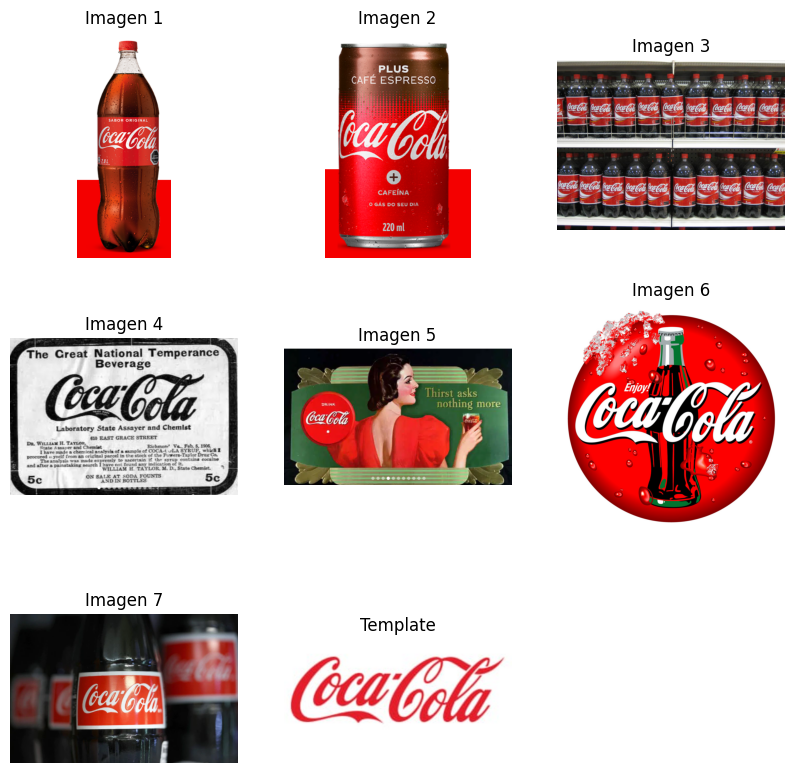

In [3]:
# Ver las imagenes
plt.figure(figsize=(10,10))
plt.subplot(3, 3, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 1')
plt.axis('off')
plt.subplot(3, 3, 2)
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 2')
plt.axis('off')
plt.subplot(3, 3, 3)
plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 3')
plt.axis('off')
plt.subplot(3, 3, 4)
plt.imshow(cv.cvtColor(img4, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 4')
plt.axis('off')
plt.subplot(3, 3, 5)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 5')
plt.axis('off')
plt.subplot(3, 3, 6)
plt.imshow(cv.cvtColor(img6, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 6')
plt.axis('off')
plt.subplot(3, 3, 7)
plt.imshow(cv.cvtColor(img7, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 7')
plt.axis('off')
plt.subplot(3, 3, 8)
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title(f'Template')
plt.axis('off')
plt.show()

In [4]:
# Trabajaremos las imagenes en escala de grises

img1_gris = cv.imread(img_path1 + '/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
img2_gris = cv.imread(img_path1 + '/coca_logo_2.png', cv.IMREAD_GRAYSCALE)
img3_gris = cv.imread(img_path1 + '/coca_multi.png', cv.IMREAD_GRAYSCALE)
img4_gris = cv.imread(img_path1 + '/coca_retro_1.png', cv.IMREAD_GRAYSCALE)
img5_gris = cv.imread(img_path1 + '/coca_retro_2.png', cv.IMREAD_GRAYSCALE)
img6_gris = cv.imread(img_path1 + '/COCA-COLA-LOGO.jpg', cv.IMREAD_GRAYSCALE)
img7_gris = cv.imread(img_path1 + '/logo_1.png', cv.IMREAD_GRAYSCALE)
template_gris = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)

En las imagenes dadas, el logo de coca cola es de color distinto al del template, algunas imagenes tienen combras, otras tienen reflejos, en otras estan distorsionadas por la forma cilindrica del producto, etc.

Los metodos normales template matching no funcionan para este caso, ya que los mismos son sensibles a cambios de rotacion, escala, el angulo en el que son vistos, o reflejos. 

Probamos agregar algunos pasos para mejorar el mecanismo de tempalte matching:
1. Filtro gaussiano (mejora la deteccion de bordes)
2. Deteccion de bordes (probamos Sobel, Canny y piramides LoG)
3. Ciclar y escalar de template para corregir la proporcion de tamaño entre las imagenes y el template
4. Como ultima estrategia, se podria modificar el template quitandole una parte a la izquierda y otra a la derecha, de modo que en vez de probar "Coca Cola", probamos "ca Co". En la mayoria de las imagenes, Coca Cola está sobre un cilindro, por lo tanto la parte inicial y la parte final de Coca Cola (osea Co y la) están distorsionadas. Remover esto nos permitiria eliminar los errores por distorsion de perspectiva.


In [5]:
def deteccion_bordes(image, 
                     blur = True, 
                     k_size_blur = (3,3),
                     sigma = 1,
                     type = 'Canny', 
                     thres1 = 0, 
                     thres2 = 255, 
                     k_size_sobel = 5,
                     pyr_steps = 5
                    ):
    if blur:
        image = cv.GaussianBlur(image, k_size_blur, sigmaX=sigma, sigmaY=sigma)
    match type:
        case 'Canny':
            edges = cv.Canny(image, thres1, thres2,L2gradient=True)
            return edges
        case 'SobelX':
            sobelx = cv.Sobel(image, ddepth = cv.CV_64F, dx = 1, dy = 0, ksize = k_size_sobel)
            return sobelx
        case 'SobelY':
            sobely = cv.Sobel(image, ddepth = cv.CV_64F, dx = 0, dy = 1, ksize = k_size_sobel)
            return sobely
        case 'SobelXY':
            sobelxy = cv.Sobel(image, ddepth = cv.CV_64F, dx = 1, dy = 1, ksize = k_size_sobel)
            return sobelxy
        case 'Pyramid':
            gaussian = []
            gaussian_layer = image.copy()
            for i in range(pyr_steps):
                gaussian_layer = cv.pyrDown(gaussian_layer)
                gaussian.append(gaussian_layer)
            
            laplacian = [gaussian[-1]]
            for i in range(len(gaussian) - 1,0,-1):
                size = (gaussian[i - 1].shape[1], gaussian[i - 1].shape[0])
                gaussian_expanded = cv.pyrUp(gaussian[i], dstsize=size)
                laplacian_layer = cv.subtract(gaussian[i-1], gaussian_expanded)
                laplacian.append(laplacian_layer)
            return laplacian

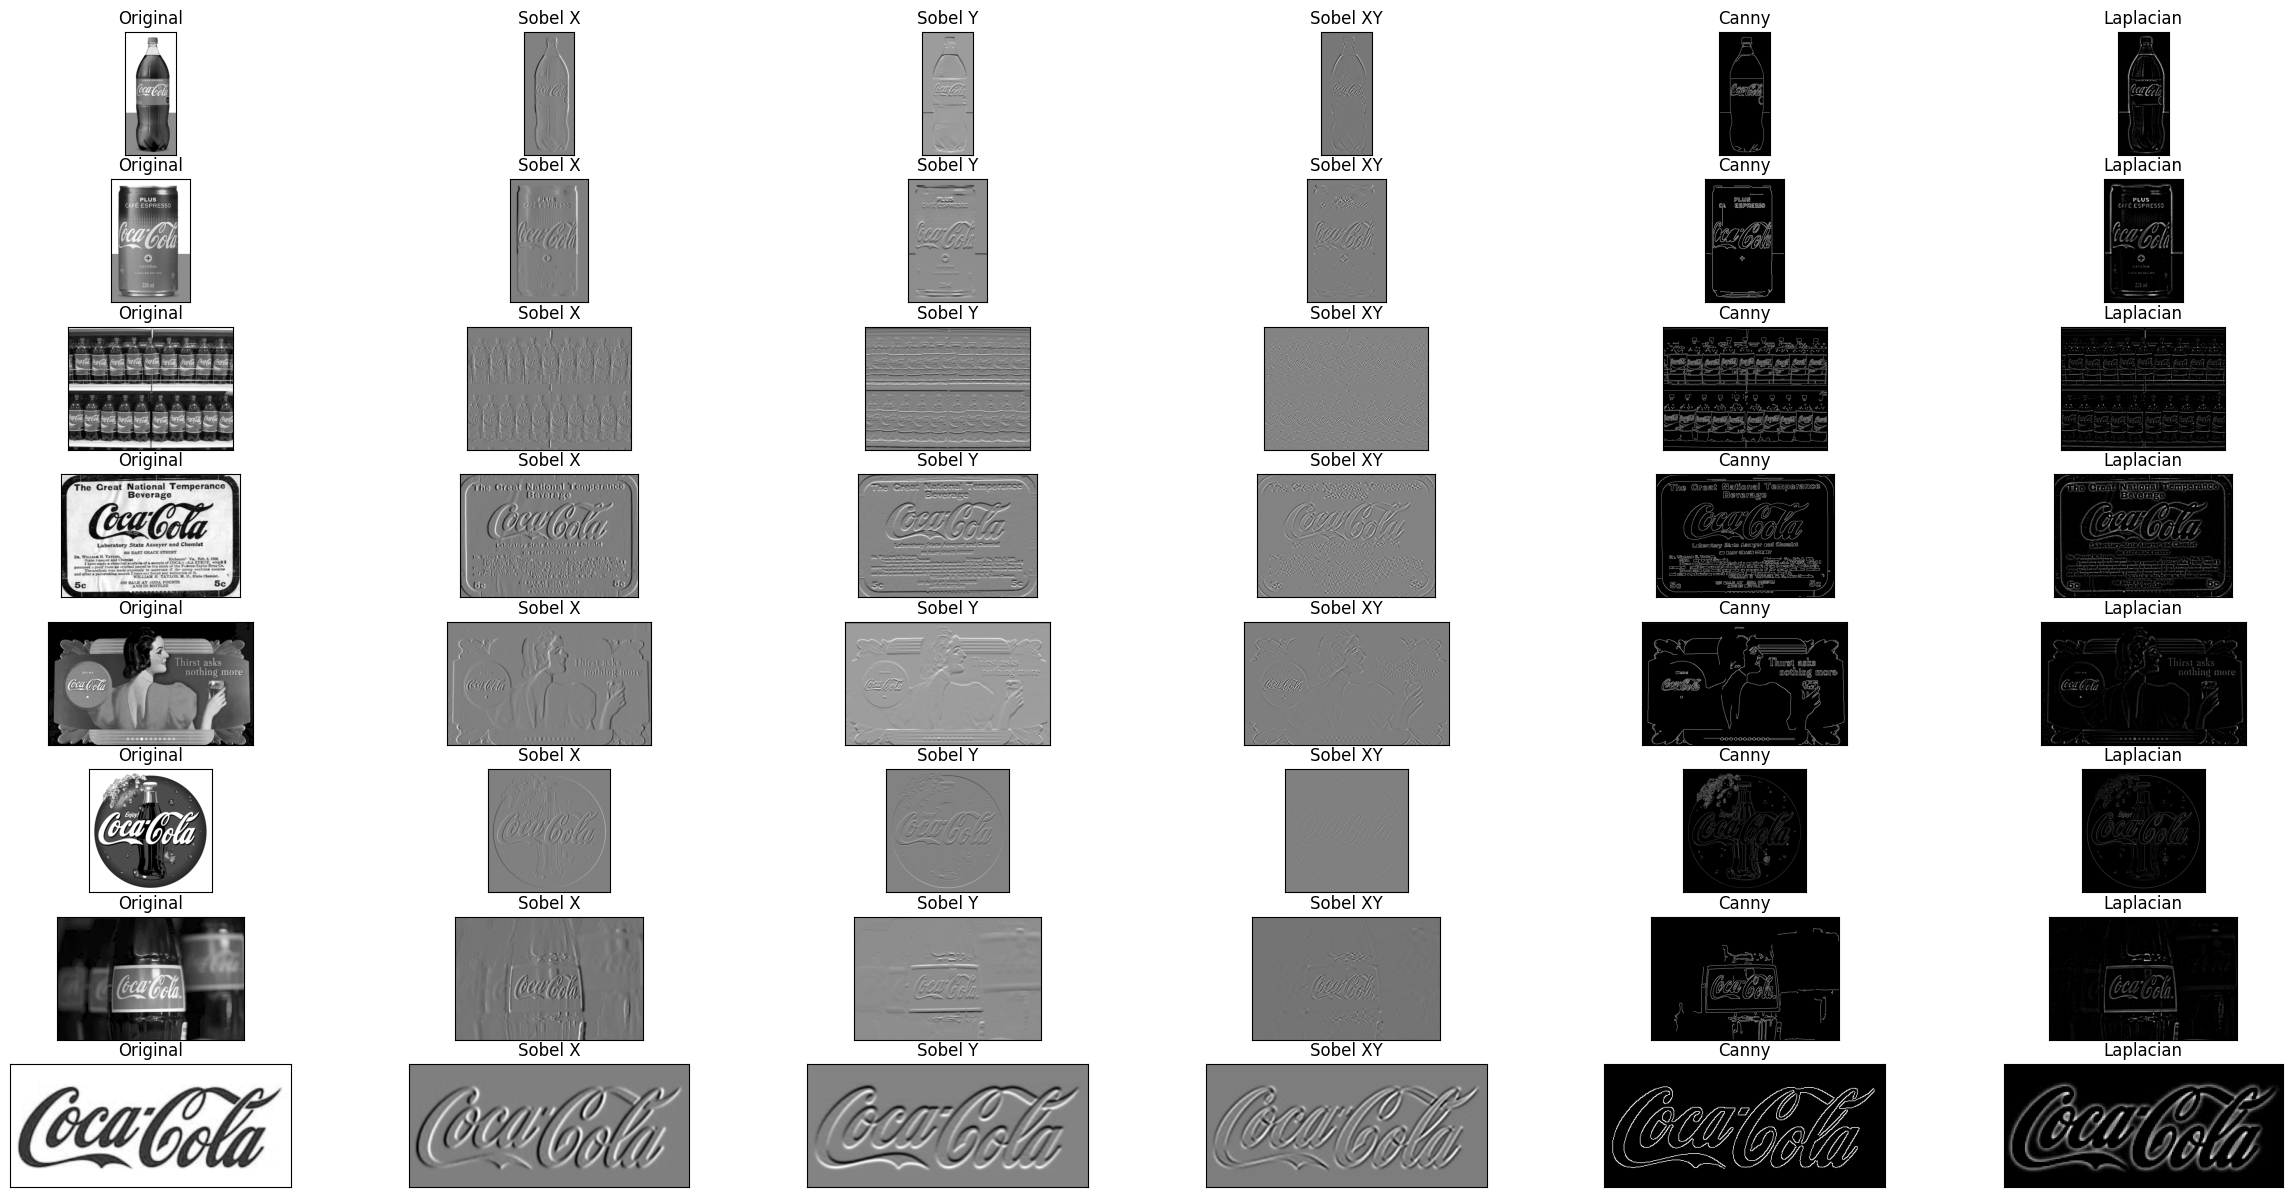

In [6]:
images = [img1_gris, img2_gris, img3_gris, img4_gris, img5_gris, img6_gris, img7_gris, template_gris]

plt.figure(figsize=(30,15))
i = 0
for image in images:
    i += 1

    sigma = 1
    kernel_size = (int(2 * np.ceil(3 * sigma) + 1), int(2 * np.ceil(3 * sigma) + 1))
    
    sobelx = deteccion_bordes(image, True, kernel_size, sigma, 'SobelX', None, None, 5, None)
    sobely = deteccion_bordes(image, True, kernel_size, sigma, 'SobelY', None, None, 5, None)
    sobelxy = deteccion_bordes(image, True, kernel_size, sigma, 'SobelXY', None, None, 5, None)
    canny = deteccion_bordes(image, True, kernel_size, sigma, 'Canny', int(max(0 ,0.5*np.median(image) )), int(min(255,1.8*np.median(image) )), None, None)
    laplacian = deteccion_bordes(image, True, kernel_size, sigma, 'Pyramid', None, None, None, 5)
    laplacian = laplacian[-1]
    
    plt.subplot(len(images), 6, i)
    plt.imshow(image,cmap = 'gray')
    plt.title(f'Original'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobelx,cmap = 'gray')
    plt.title(f'Sobel X'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobely,cmap = 'gray')
    plt.title(f'Sobel Y'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobelxy,cmap = 'gray')
    plt.title(f'Sobel XY'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(canny,cmap = 'gray')
    plt.title(f'Canny'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(laplacian,cmap = 'gray')
    plt.title(f'Laplacian'),plt.xticks([]),plt.yticks([])

plt.show()

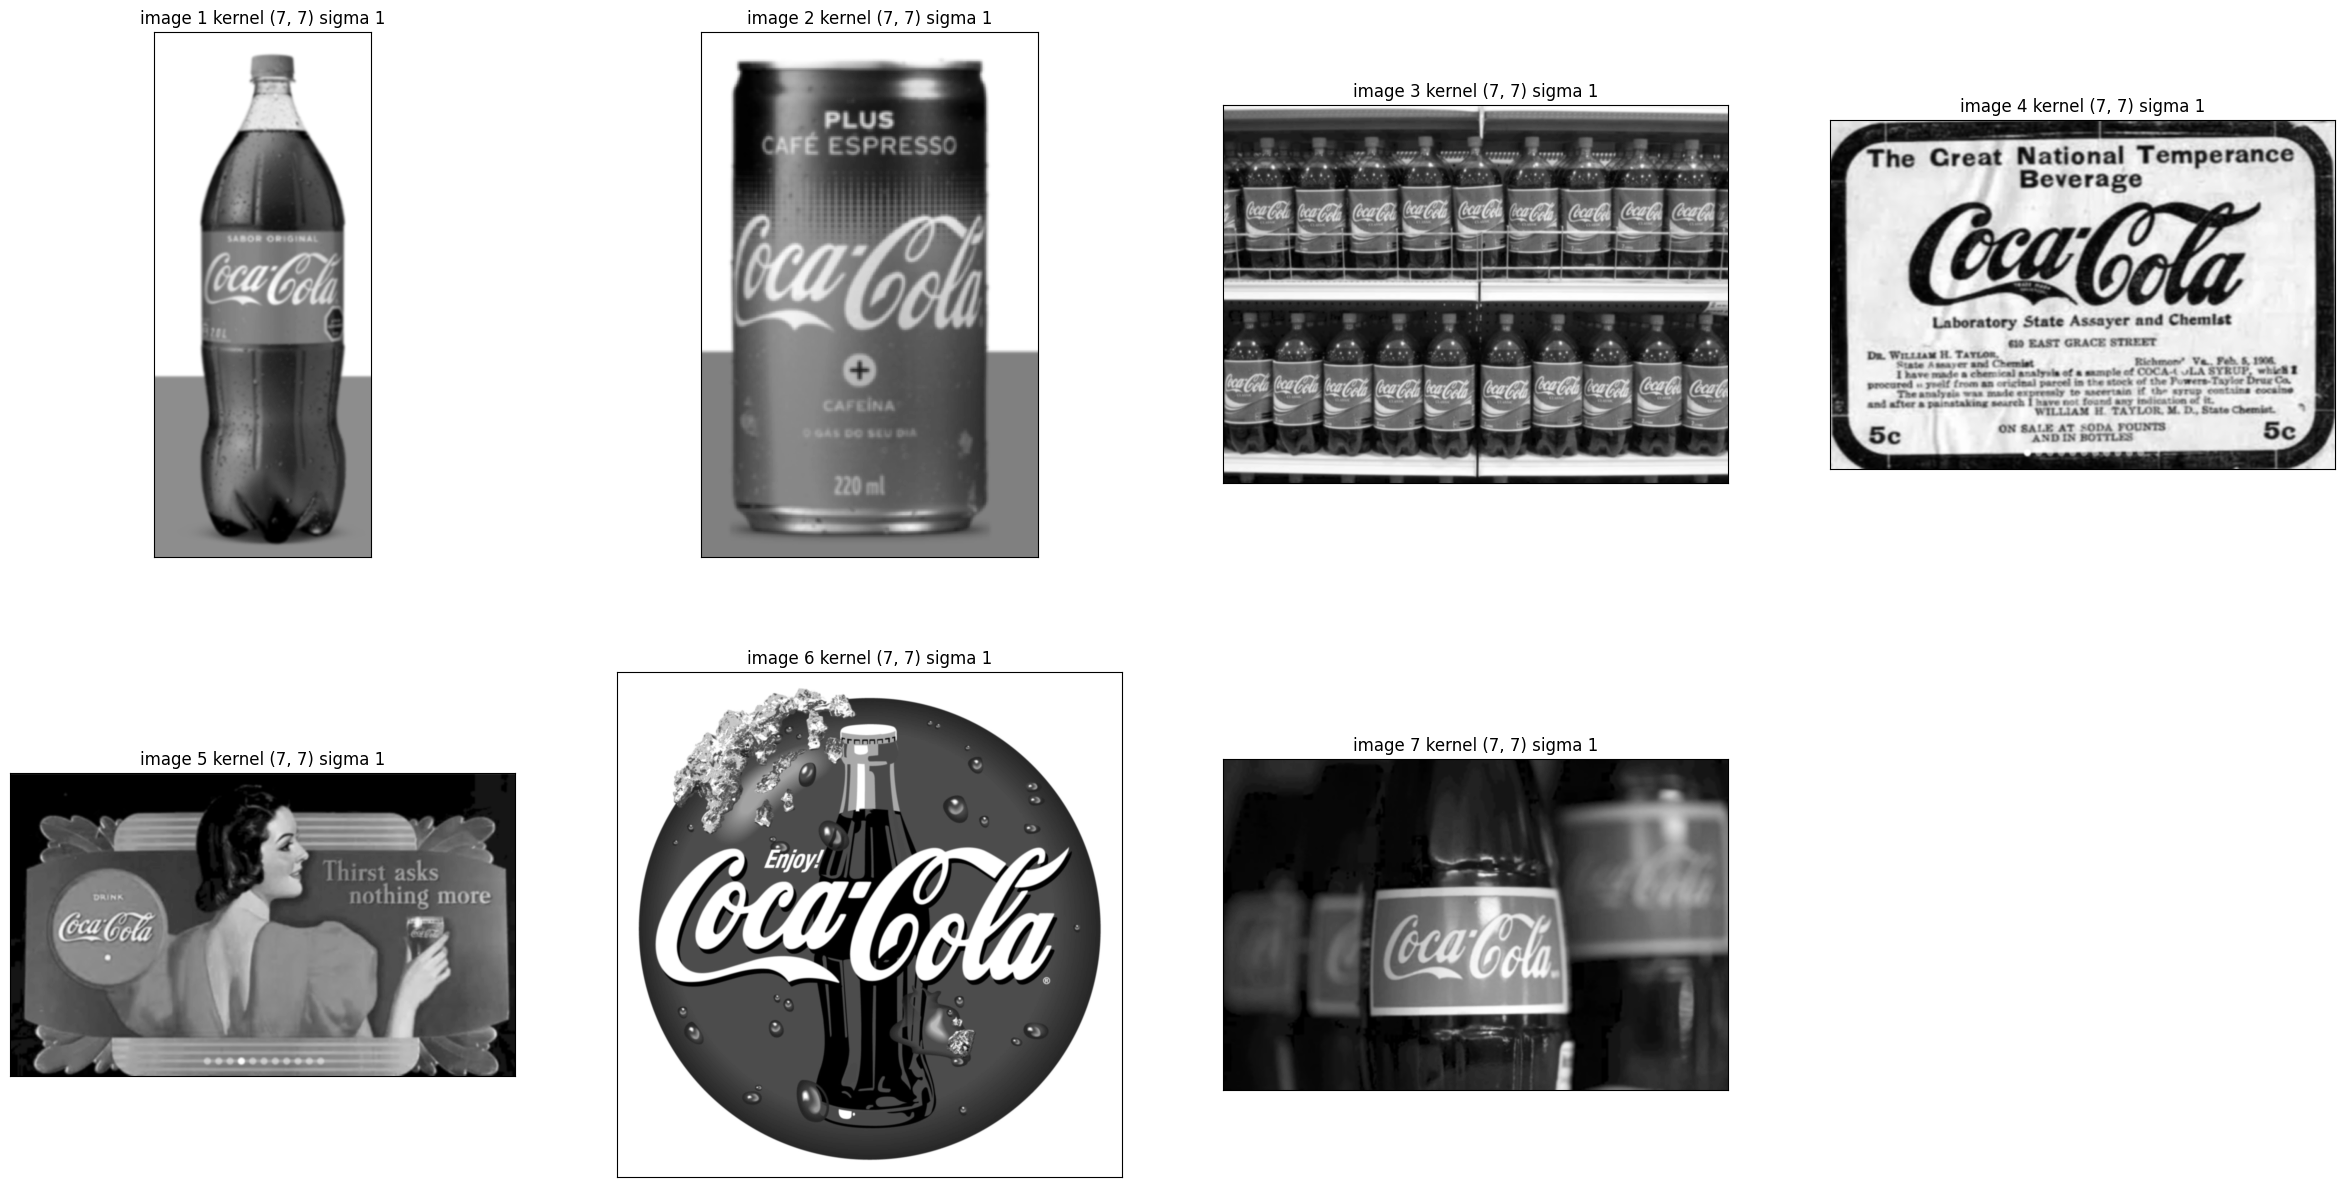

In [10]:
images = [img1_gris, img2_gris, img3_gris, img4_gris, img5_gris, img6_gris, img7_gris]

plt.figure(figsize=(30,15))
i = 0
for image in images:
    i += 1

    sigma = 1
    kernel_size = (int(2 * np.ceil(3 * sigma) + 1), int(2 * np.ceil(3 * sigma) + 1))
    
    blurred_image = cv.GaussianBlur(image, kernel_size, sigma)
    
    plt.subplot(100 * int(np.round(len(images)/4,0)) + 10 * 4 + i)
    plt.imshow(blurred_image,cmap = 'gray')
    plt.title(f'image {i} kernel {kernel_size} sigma {sigma}')
    plt.xticks([])
    plt.yticks([])

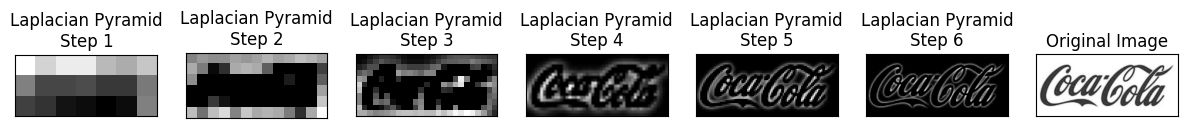

In [11]:
scales = 6
edges_pyr = deteccion_bordes(template_gris, True, (3,3), 3, 'Pyramid', None, None, None, scales)

plt.figure(figsize=(15,10))
for i in range(scales):
    plt.subplot(1, scales+1, i+1)
    plt.imshow(edges_pyr[i], cmap='gray')
    plt.title(f'Laplacian Pyramid\nStep {i+1}'), plt.xticks([]), plt.yticks([])

plt.subplot(1, scales+1, scales+1)
plt.imshow(template_gris,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
def scale_image(image, scale):
    copied_image = image.copy()
    resized_image = cv.resize(copied_image, None, fx = scale, fy = scale)
    return resized_image

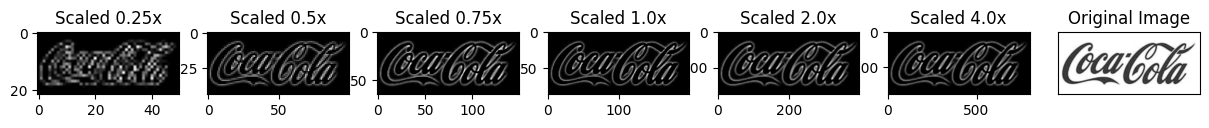

In [13]:
scales = [0.25, 0.5, 0.75, 1., 2., 4.]

plt.figure(figsize=(15,10))
for i in range(len(scales)):
    plt.subplot(1, len(scales)+1, i+1)
    plt.imshow(scale_image(edges_pyr[-1], scales[i]), cmap='gray')
    plt.title(f'Scaled {scales[i]}x')

plt.subplot(1, len(scales)+1, len(scales)+1)
plt.imshow(template_gris,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

Escalar hacia abajo hace que se pierda calidad y por lo tanto informacion. 
Como el template y las imagenes tienen tamaños y proporciones distintas, hay que tomar una decision para no perder la informacion escalando hacia abajo.
Lo que se hará es escalar las imagenes de modo que el template siempre entre en las mismas.
Como las proporciones son distintas para todas las imagenes, esto significa que el template debe entrar tanto vertical como horizontalmente dentro de la imagen.

A la hora de hacer template matching, si queremos encontrar mas de una posicion, debemos guardar todas las posiciones donde haya una un match alto.
Sin embargo, si en determinada zona tenemos un match alto y nos movemos un pixel hacia la derecha, es probable que el match siga siendo alto.
Para esto utilizaremos un algoritmo llamado NMS (Non-Maximum Suppression) que permite elegir el bounding box mas adecuado.
Este algoritmo utiliza otro llamado IoU (Intersection over Union) que mide el area de interseccion de dos bounding boxes y el area de union de dos bounding boxes.
Mientras mayor sea el numero, mas similares son los bounding boxes y se pueden unir en uno solo.

In [293]:
def calculate_iou(box1, box2):
    # Coordenadas
    x1_tl, y1_tl = box1[0]
    x2_tl, y2_tl = box2[0]
    x1_br, y1_br = box1[1]
    x2_br, y2_br = box2[1]

    # Area de interseccion
    x_overlap = max(0, min(x1_br, x2_br) - max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br) - max(y1_tl, y2_tl))
    intersection_area = x_overlap * y_overlap

    # Area de union
    box1_area = (x1_br - x1_tl) * (y1_br - y1_tl)
    box2_area = (x2_br - x2_tl) * (y2_br - y2_tl)
    union_area = box1_area + box2_area - intersection_area

    # Calcular IoU
    iou = intersection_area / union_area
    return iou

def non_max_suppression(bounding_boxes, confidence_scores, iou_threshold):
    selected_boxes = []
    selected_scores = []
    #print(np.max(confidence_scores))

    while bounding_boxes:
        # Buscar el indice del bounding box con mayor puntaje de confianza
        max_index = np.argmax(confidence_scores)
        # Sacar el bounding box de la lista
        box = bounding_boxes.pop(max_index)
        score = confidence_scores.pop(max_index)

        # Agregarlo a los outputs
        selected_boxes.append(box)
        selected_scores.append(score)

        # Ciclar el resto de los bounding box con IoU para eliminar los que se pueda
        indices_to_remove = []
        for i in range(len(bounding_boxes)):
            iou = calculate_iou(box, bounding_boxes[i])
            if iou > iou_threshold:
                indices_to_remove.append(i)

        indices_to_remove.reverse()
        for idx in indices_to_remove:
            bounding_boxes.pop(idx)
            confidence_scores.pop(idx)

    return selected_boxes, selected_scores

In [195]:
def object_detection(img, template, method, detect_thres, iou_thres, scale_factor, modding_template):
    w, h = template.shape[::-1]
    dw = int(template.shape[1] // scale_factor)
    dh = int(template.shape[0] // scale_factor)

    res = cv.matchTemplate(img, template, eval(method))
    
    # Buscamos todos los puntos en los que se supera el threshold
    loc = np.where(res >= detect_thres)
    bounding_boxes = []
    confidence_scores = []
    
    for pt in zip(*loc[::-1]):
        # Coordenadas del bounding box
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)

        modding_template = False
        if modding_template:
            top_left = (top_left[0] - dh, top_left[1] - dw)
            bottom_right = (bottom_right[0] - dh, bottom_right[1] - dw)

        bbox = (top_left, bottom_right)

        # Puntaje de confianza
        confidence_score = res[pt[1], pt[0]]

        bounding_boxes.append(bbox)
        confidence_scores.append(confidence_score)
        
    # Utilizar non-maximum suppression para eliminar bounding boxes encimados
    selected_boxes, selected_scores = non_max_suppression(bounding_boxes, confidence_scores, iou_thres)

    return selected_boxes, selected_scores

In [190]:
def detect_logo(image, template, method = 'cv.TM_CCOEFF_NORMED', scales = 10, blur = True, k_size_blur = (3,3), sigma = 1, edge_detection_type = 'Canny', thres1 = 0, thres2 = 255, k_size_sobel = 5, pyr_steps = 5, detect_thres = 0.75, iou_thres = 0.5, modding_template = False):
    # Variables temporales
    temp_image = image.copy()
    temp_template = template.copy()
    global_bounding_boxes = []
    global_confidence_scores = []

    # Aplicar filtro gaussiano y deteccion de bordes a la imagen y template
    filtered_temp_image = deteccion_bordes(temp_image, blur, k_size_blur, sigma, edge_detection_type, thres1, thres2, k_size_sobel, pyr_steps)
    filtered_temp_template = deteccion_bordes(temp_template, blur, k_size_blur, sigma, edge_detection_type, thres1, thres2, k_size_sobel, pyr_steps)
    
    # En caso de elegir piramides LoG, elegimos la de mayor calidad
    if edge_detection_type == 'Pyramid':
        filtered_temp_image = filtered_temp_image[-1]
        filtered_temp_template = filtered_temp_template[-1]
    
    # Escalar imagenes y detectar objetos
    scale_factors = np.linspace(0.1, 10, num=scales)
    for scale_factor in scale_factors:
        scaled_filtered_temp_image = cv.resize(filtered_temp_image, None, fx = scale_factor, fy = scale_factor)

        if (scaled_filtered_temp_image.shape[0] < filtered_temp_template.shape[0] or scaled_filtered_temp_image.shape[1] < filtered_temp_template.shape[1]):
            continue

        scaled_bounding_boxes, confidence_scores = object_detection(scaled_filtered_temp_image, filtered_temp_template, method, detect_thres, iou_thres, scale_factor, modding_template)
        
        bounding_boxes = [[(int(x // scale_factor), int(y // scale_factor)) for x, y in pair] for pair in scaled_bounding_boxes]
        global_bounding_boxes.append(bounding_boxes)
        global_confidence_scores.append(confidence_scores)
    return global_bounding_boxes, global_confidence_scores

In [ ]:
def test_image(image, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template):
    # Muchas de las imagenes estan en objetos cilindricos, por lo que el inicio y final de 
    # la palabra Coca Cola está distorsionado por perspectiva.
    # modding_template quita del template un cuarto de la derecha y un cuarto de la izquierda 
    if modding_template:
        modded_width = template_gris.shape[1] // 4
        mod_template_gris = template_gris[:, modded_width : -modded_width]
        template_gris = mod_template_gris.copy()

    test_img_gris = image

    # El IoU threshold de este punto elimina bounding boxes en una misma escala
    bounding_boxes, confidence_scores = detect_logo(test_img_gris, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, modding_template)

    flat_confidence_scores = []
    flat_bounding_boxes = []

    for sublist_scores, sublist_boxes in zip(confidence_scores, bounding_boxes):
        for score, box in zip(sublist_scores, sublist_boxes):
            if sublist_scores:
                flat_confidence_scores.append(score)
                flat_bounding_boxes.append(box)

    # El IoU threshold de este punto elimina bounding boxes entre distintas escalas
    print(flat_confidence_scores)
    mod_flat_bounding_boxes, mod_flat_confidence_scores = non_max_suppression(flat_bounding_boxes,flat_confidence_scores, iou_thres2)
    print(mod_flat_confidence_scores)
    return mod_flat_bounding_boxes, mod_flat_confidence_scores


In [264]:
def draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template):
    colors = [(random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)) for _ in range(30)]

    img_salida = image.copy()
    #for img_boxes, img_confidences in zip(bounding_boxes, confidence_scores):
    for i, (bbox, confidence) in enumerate(zip(bounding_boxes, confidence_scores)):
        top_left, bottom_right = bbox
        modding_template = False
        if modding_template:
            top_left_x, top_left_y = top_left
            top_left_x -= template.shape[1] // 4
            top_left = (top_left_x, top_left_y)
            bottom_right_x, bottom_right_y = bottom_right
            bottom_right_x += template.shape[1] // 4
            bottom_right = template.shape[1] // 4
            bottom_right = (bottom_right_x, bottom_right_y)
        color = colors[i % len(colors)]  # Select a color from the predefined list
        cv.rectangle(img_salida, top_left, bottom_right, color, 2)
        
        # Display the confidence score alongside the bounding box
        cv.putText(img_salida, f'Confidence: {confidence*100:.0f}%', (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(img_salida)
    plt.title("Logos detectados")
    plt.xticks([])
    plt.yticks([])

In [313]:
image = cv.imread(img_path1 + '/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
template = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 50
blur = True
blur_kernel = (3,3)
blur_sigma = 2
edge_method = 'Pyramid'
canny_thres1 = 150
canny_thres2 = 255
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.25
iou_thres1 = 1
iou_thres2 = 1
modding_template = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template)
image = cv.imread(img_path1 + '/coca_logo_1.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template)

[[(11, 99), (97, 137)], [(10, 99), (96, 137)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 92), (79, 103)], [(53, 91), (79, 103)], [(53, 91), (79, 103)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 91), (79, 103)], [(53, 92), (79, 103)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 91), (79, 103)], [(53, 91), (79, 102)], [(53, 91), (79, 102)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 91), (79, 103)], [(53, 92), (79, 103)], [(53, 91), (79, 103)], [(53, 92), (79, 103)], [(53, 91), (79, 102)], [(53, 92), (79, 103)], [(53, 91), (78, 103)], [(53, 92), (78, 103)], [(53, 92), (78, 103)], [(54, 91), (79, 103)], [(53, 91), (78, 103)], [(54, 92), (79, 103)], [(53, 91), (78, 102)], [(53, 92), (78, 103)], [(54, 91), (79, 102)], [(53, 92), (78, 103)], [(53, 91), (78, 102)], [(54, 92),

KeyboardInterrupt: 

[[(0, 108), (233, 210)], [(49, 30), (196, 94)], [(57, 34), (193, 93)], [(62, 41), (190, 97)], [(69, 42), (189, 95)], [(114, 112), (211, 154)], [(104, 57), (185, 93)], [(65, 38), (143, 72)], [(110, 60), (184, 93)], [(67, 39), (142, 71)], [(69, 40), (141, 71)], [(112, 60), (184, 91)], [(72, 41), (142, 72)], [(112, 61), (181, 92)], [(73, 42), (140, 71)], [(117, 60), (185, 89)], [(113, 66), (180, 95)], [(128, 60), (196, 90)], [(74, 43), (139, 71)], [(119, 61), (184, 89)], [(114, 66), (179, 94)], [(132, 61), (197, 90)], [(76, 44), (138, 71)], [(120, 62), (183, 89)], [(122, 66), (185, 93)], [(133, 62), (196, 89)], [(78, 44), (139, 71)], [(121, 62), (182, 89)], [(134, 62), (195, 89)], [(118, 66), (179, 93)], [(106, 324), (167, 351)], [(80, 45), (139, 71)], [(125, 63), (184, 89)], [(135, 63), (194, 89)], [(107, 325), (166, 351)], [(110, 66), (169, 92)], [(119, 67), (179, 92)], [(130, 66), (189, 92)], [(81, 46), (139, 71)], [(125, 63), (183, 89)], [(105, 66), (162, 91)], [(135, 63), (193, 88)],

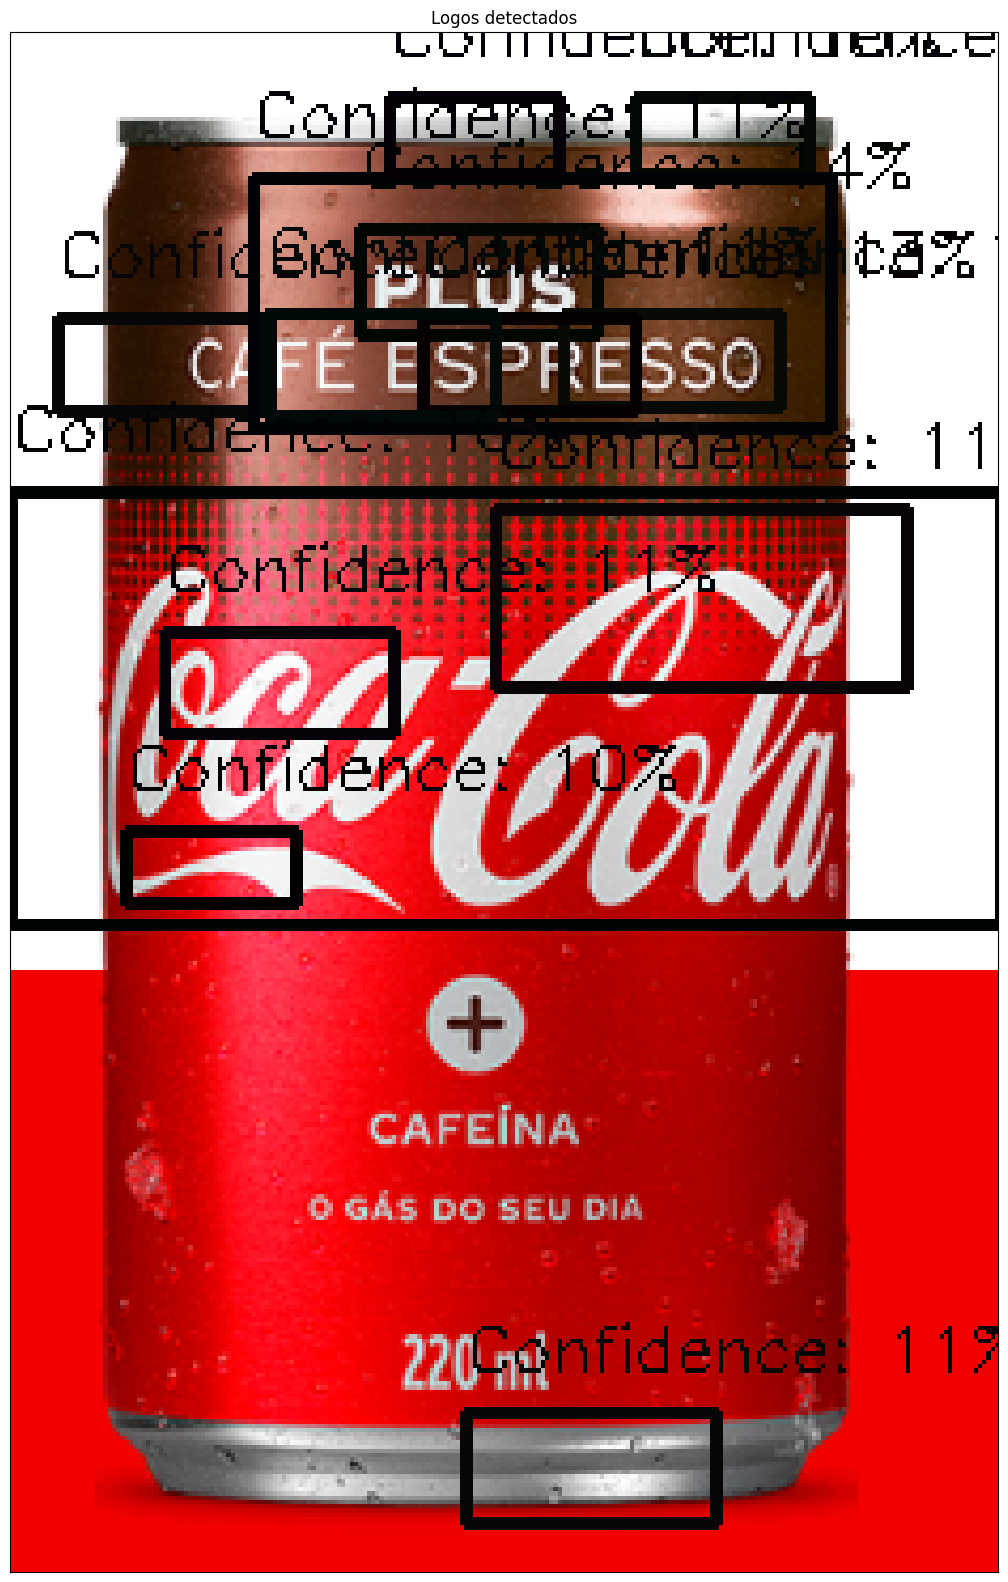

In [279]:
image = cv.imread(img_path1 + '/coca_logo_2.png', cv.IMREAD_GRAYSCALE)
template = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 50
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 150
canny_thres2 = 255
sobel_kernel = 5
pyramid_steps = 5
detect_thres = 0.10
iou_thres1 = 0.7
iou_thres2 = 0.2
modding_template = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template)
image = cv.imread(img_path1 + '/coca_logo_2.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template)

[[(228, 427), (317, 466)], [(398, 429), (487, 468)], [(235, 435), (295, 461)], [(367, 150), (427, 176)], [(164, 442), (216, 465)], [(377, 162), (429, 184)], [(422, 446), (473, 469)], [(289, 162), (341, 185)], [(504, 439), (555, 462)], [(124, 166), (175, 189)], [(78, 430), (129, 452)], [(572, 446), (624, 468)], [(7, 438), (52, 458)], [(578, 447), (623, 466)], [(291, 164), (336, 184)], [(452, 169), (497, 188)], [(118, 169), (163, 189)], [(379, 164), (424, 184)], [(10, 440), (50, 458)], [(382, 166), (422, 184)], [(578, 127), (618, 144)], [(321, 436), (361, 453)], [(202, 498), (242, 516)], [(379, 222), (419, 239)], [(108, 171), (148, 188)], [(456, 170), (496, 187)], [(126, 171), (166, 188)], [(276, 166), (316, 183)], [(158, 127), (198, 145)], [(487, 446), (527, 464)], [(500, 444), (540, 462)], [(443, 170), (483, 188)]]
[[(10, 440), (50, 458)], [(382, 166), (422, 184)], [(578, 127), (618, 144)], [(578, 447), (623, 466)], [(321, 436), (361, 453)], [(202, 498), (242, 516)], [(379, 222), (419,

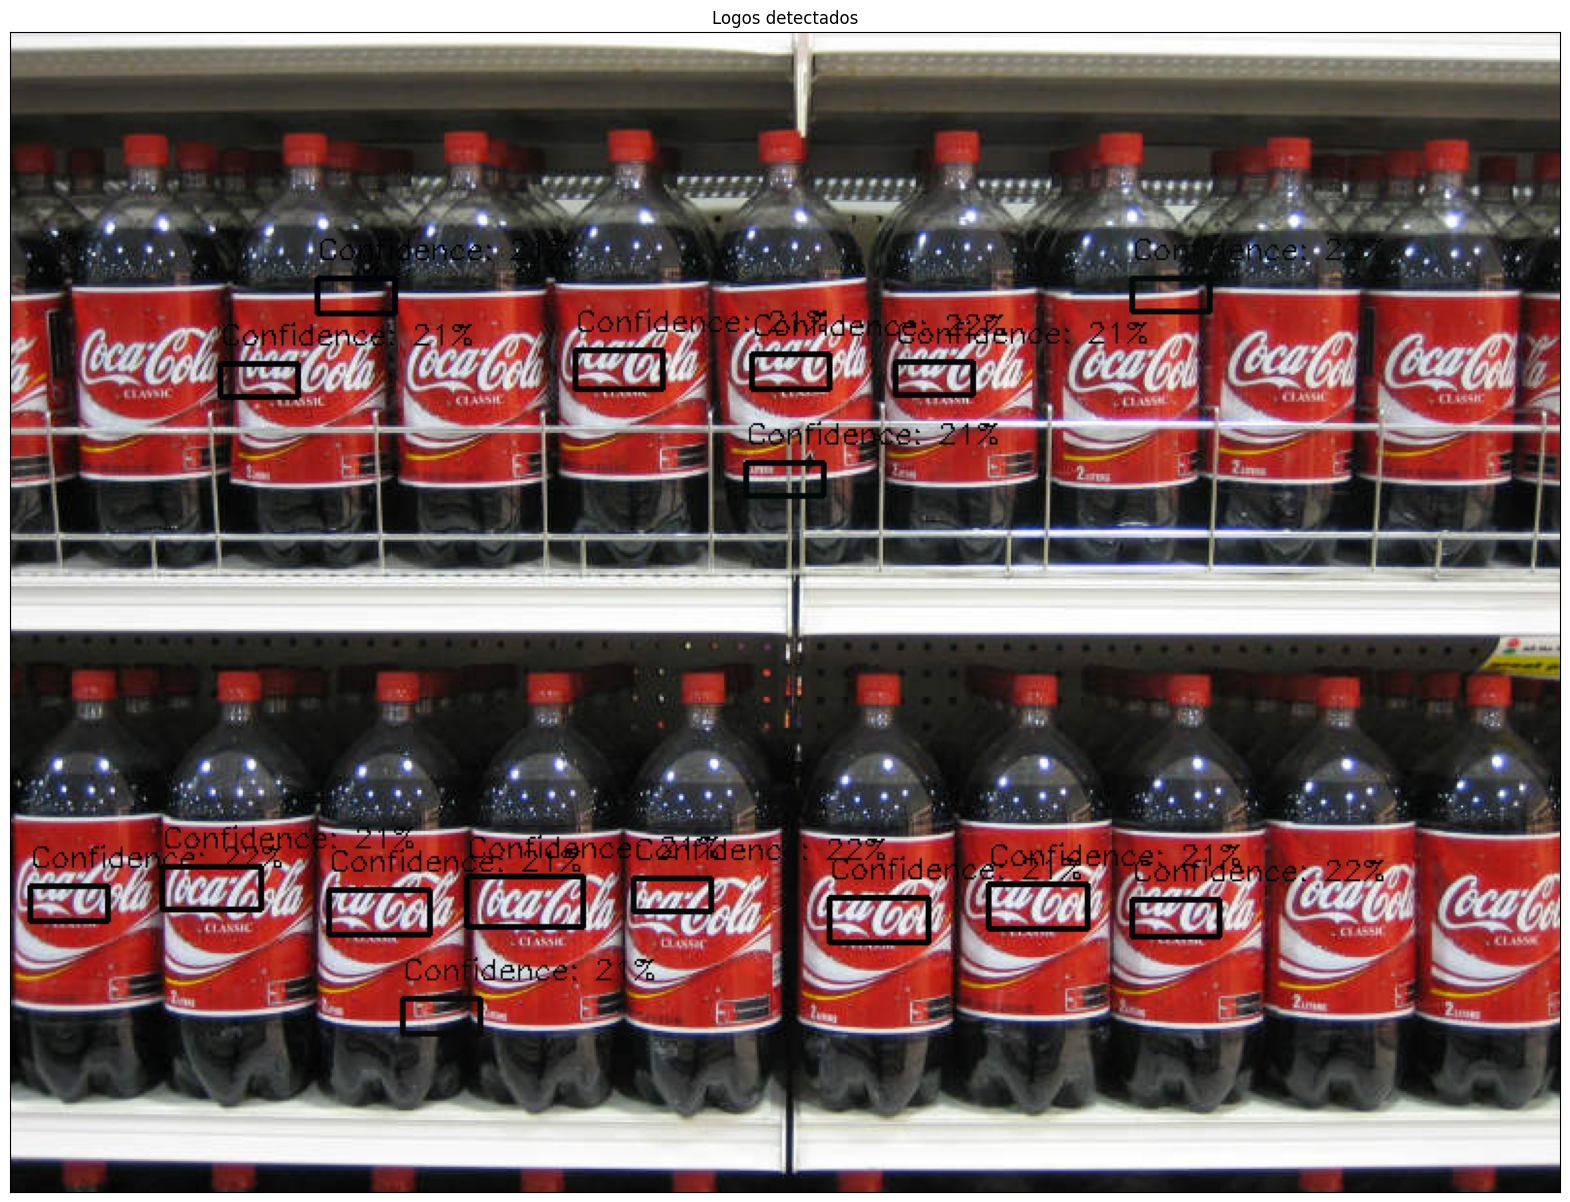

In [276]:
image = cv.imread(img_path1 + '/coca_multi.png', cv.IMREAD_GRAYSCALE)
template = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[3]
scales = 10
blur = True
blur_kernel = (7,7)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 150
canny_thres2 = 255
sobel_kernel = 5
pyramid_steps = 5
detect_thres = 0.21
iou_thres1 = 0.7
iou_thres2 = 0.2
modding_template = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template)
image = cv.imread(img_path1 + '/coca_multi.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template)

[[(353, 277), (401, 292)], [(354, 277), (401, 292)], [(354, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(354, 277), (401, 292)], [(354, 277), (401, 292)], [(354, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(354, 277), (401, 292)], [(354, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(353, 277), (401, 292)], [(354, 277), (401, 292)], [(494, 275), (542, 290)], [(353, 277), (401, 292)], [(494, 275), (542, 290)], [(494, 275), (542, 290)], [(354, 276), (401, 292)], [(354, 277), (401, 292)], [(495, 276), (541, 290)], [(495, 276), (541, 290)], [(495, 276), (541, 290)], [(495, 276), (541, 290)], [(495, 275), (541, 290)], [(495, 275), (541, 290)], [(495, 276), (541, 290)], [(495, 276), (541, 290)], [(495, 276), (541, 290)], [(495, 275), (541, 290)], [(495, 276), (541, 290)], [(495, 276)

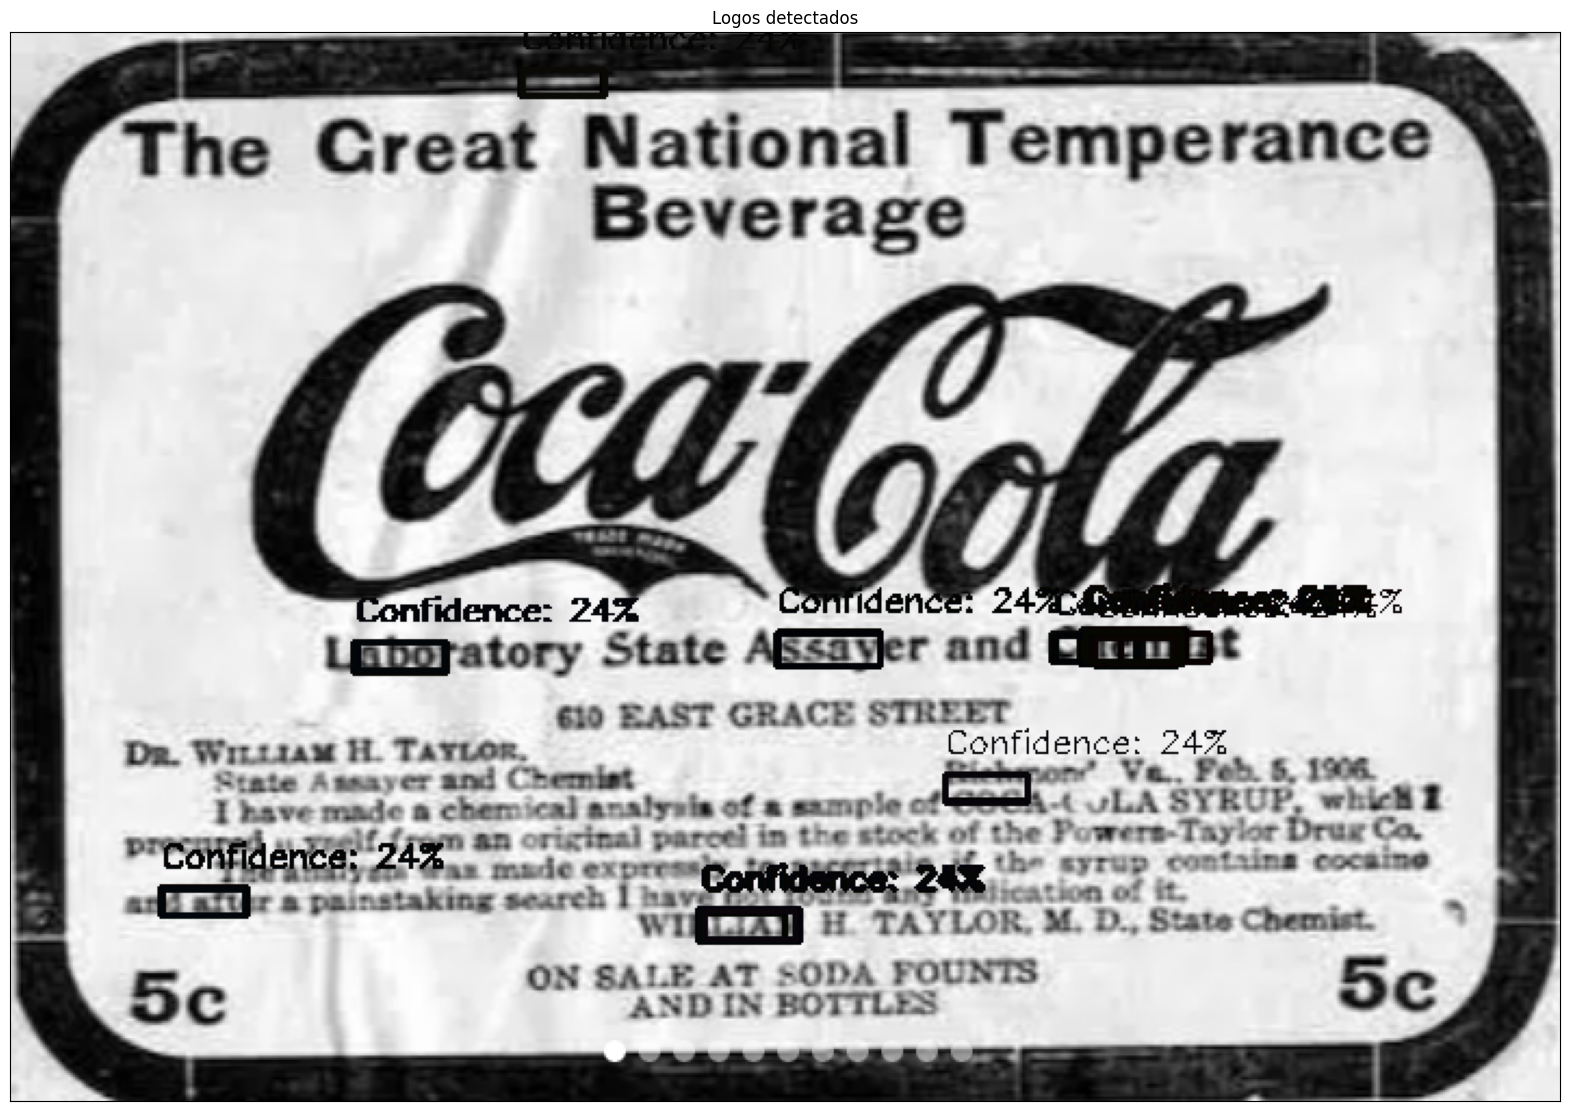

In [305]:
image = cv.imread(img_path1 + '/coca_retro_1.png', cv.IMREAD_GRAYSCALE)
template = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[3]
scales = 30
blur = True
blur_kernel = (7,7)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 150
canny_thres2 = 255
sobel_kernel = 5
pyramid_steps = 5
detect_thres = 0.24
iou_thres1 = 1
iou_thres2 = 1
modding_template = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template)
image = cv.imread(img_path1 + '/coca_retro_1.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template)